Epoch 1/5: 100%|██████████| 225/225 [11:21<00:00,  3.03s/it]


Epoch 1: Train Acc: 81.29%, Val Acc: 96.80%


Epoch 2/5: 100%|██████████| 225/225 [10:45<00:00,  2.87s/it]


Epoch 2: Train Acc: 94.64%, Val Acc: 96.80%


Epoch 3/5: 100%|██████████| 225/225 [09:53<00:00,  2.64s/it]


Epoch 3: Train Acc: 96.64%, Val Acc: 94.80%


Epoch 4/5: 100%|██████████| 225/225 [07:57<00:00,  2.12s/it]


Epoch 4: Train Acc: 97.16%, Val Acc: 96.40%


Epoch 5/5: 100%|██████████| 225/225 [06:04<00:00,  1.62s/it]


Epoch 5: Train Acc: 97.41%, Val Acc: 96.40%


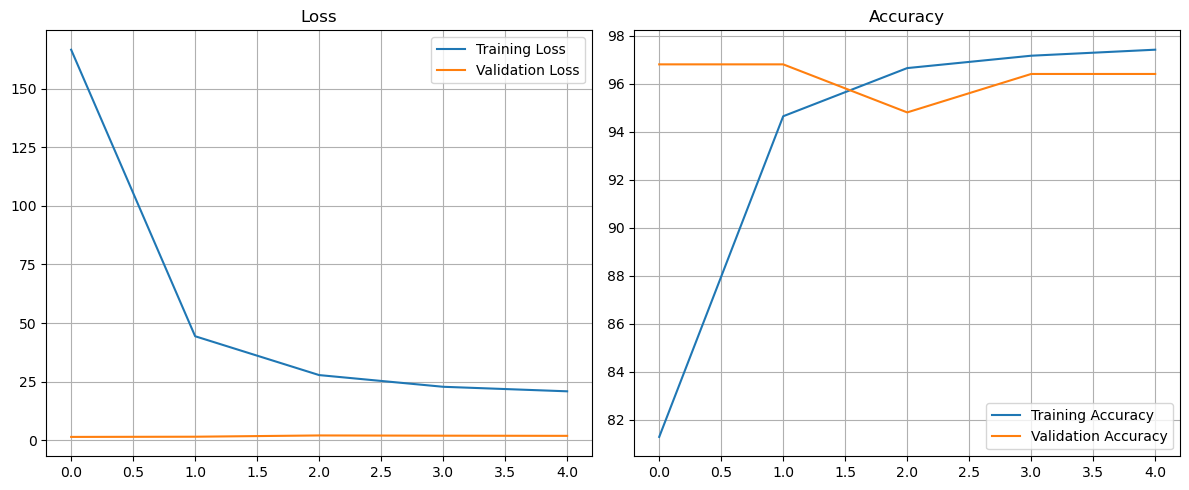

Test Accuracy: 97.60%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       0.71      1.00      0.83         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       0.71      1.00      0.83         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [2]:
# Import necessary programmes 
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets, models
from torchvision.models import ResNet50_Weights

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Transforms - loads default pretrained weights for ResNet50 (trained on ImageNet)
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

# Dictionary-style dataset and dataloader setup
data_transforms = {
    'train': transform,
    'valid': transform,
    'test': transform
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

dataloaders = {
    split: DataLoader(image_datasets[split], batch_size=32, shuffle=(split == 'train'), num_workers=4)
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Load ResNet50 model with pretrained weights
model = models.resnet50(weights=weights)
# Replace the final classification layer with dropout + new head
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

# Freeze all layers, then unfreeze layer4 and classifier for partial fine-tuning
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")


In [3]:
# Visualise confused species pairs
def show_confused_species(dataset_dir, confused_pairs, n_samples=3):
    """
    This function will display sample images of species the model confused with one another side-by-side.
    """
    test_dir = Path(dataset_dir) / "test"

    for true_class, pred_class in confused_pairs:
        true_imgs = list((test_dir / true_class).glob("*"))
        pred_imgs = list((test_dir / pred_class).glob("*"))

        true_samples = random.sample(true_imgs, min(n_samples, len(true_imgs)))
        pred_samples = random.sample(pred_imgs, min(n_samples, len(pred_imgs)))

        print(f"\nConfused: '{true_class}' predicted as '{pred_class}'")

        fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 3, 5))

        for i in range(n_samples):
            # Actual species images
            if i < len(true_samples):
                axes[0, i].imshow(Image.open(true_samples[i]))
                axes[0, i].set_title(true_class, fontsize=9)
            axes[0, i].axis('off')

            # Predicted species images
            if i < len(pred_samples):
                axes[1, i].imshow(Image.open(pred_samples[i]))
                axes[1, i].set_title(pred_class, fontsize=9)
            axes[1, i].axis('off')

        plt.suptitle(f"'{true_class}' ↔ '{pred_class}'", fontsize=12)
        plt.tight_layout()
        plt.show()


Confused: 'CLEARWING MOTH' predicted as 'HUMMING BIRD HAWK MOTH'


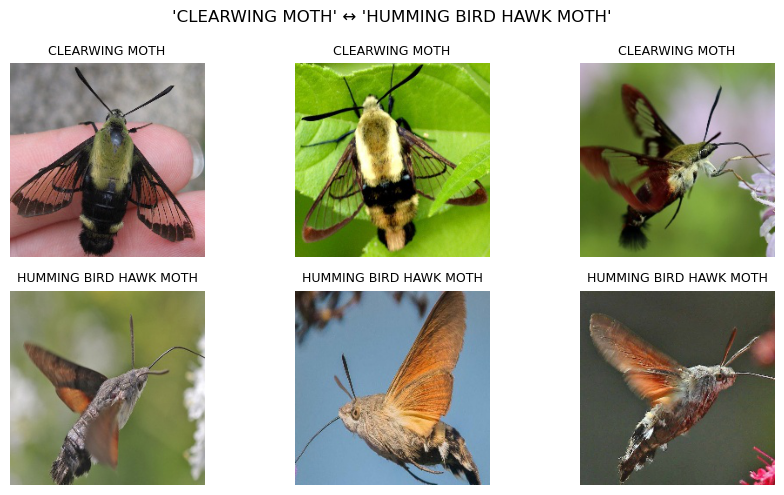


Confused: 'MUSLIN MOTH' predicted as 'BIRD CHERRY ERMINE MOTH'


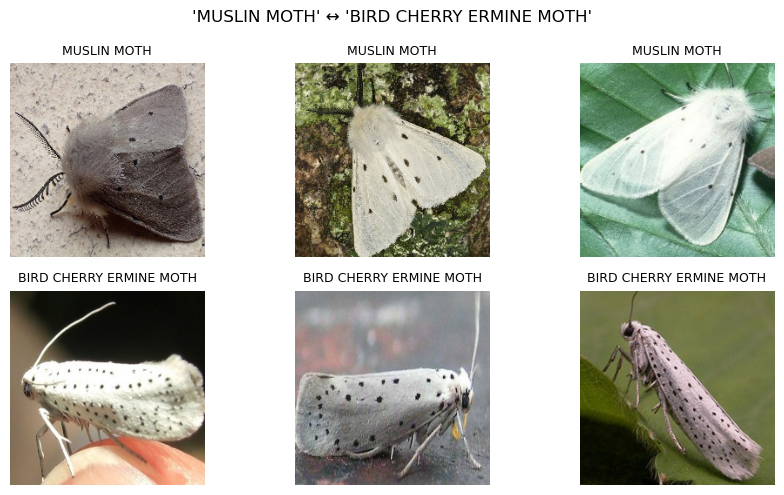


Confused: 'RUSTY DOT PEARL MOTH' predicted as 'SQUARE SPOT RUSTIC MOTH'


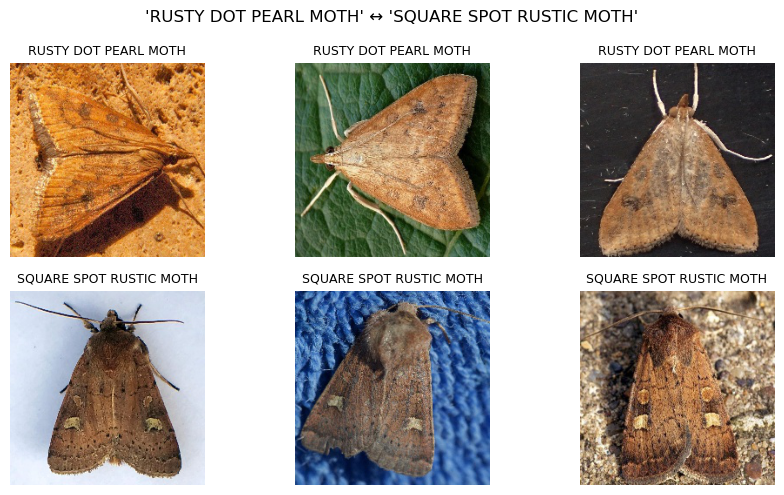


Confused: 'SUSSEX EMERALD MOTH' predicted as 'BLOTCHED EMERALD MOTH'


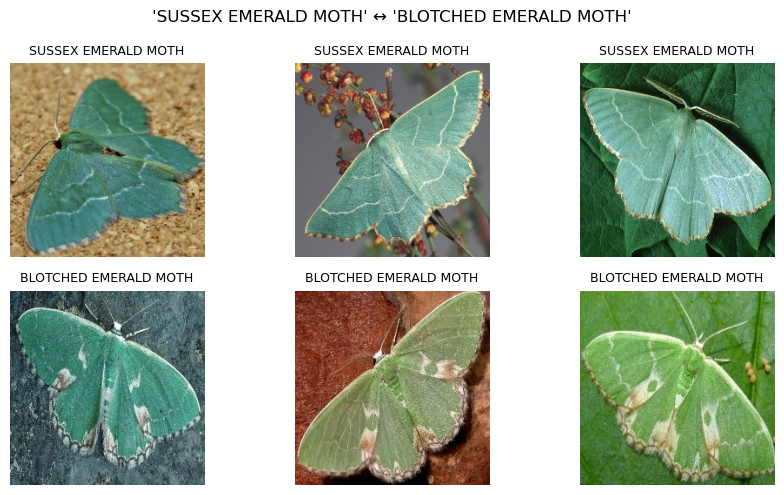

In [4]:
# Define confused class pairs based on the confusion matrix output
confused_pairs_to_plot = [
    ("CLEARWING MOTH", "HUMMING BIRD HAWK MOTH"),
    ("MUSLIN MOTH", "BIRD CHERRY ERMINE MOTH"),
    ("RUSTY DOT PEARL MOTH", "SQUARE SPOT RUSTIC MOTH"),
    ("SUSSEX EMERALD MOTH", "BLOTCHED EMERALD MOTH")
]

# Call the visualisation function
show_confused_species("../data/kaggle-dataset/archive", confused_pairs_to_plot)